In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import warnings
# warnings.filterwarnings("ignore")

2023-11-15 11:44:38.297942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 11:44:38.430074: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 11:44:38.434076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-15 11:44:38.434089: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# e = empty
img_dirs = glob.glob("./ocr_data/upper/*")
labels = [img_dir.split("/")[-1].split(".")[0] for img_dir in img_dirs]
# labels = [label if len(label)==5 else label+"e" for label in labels]
characters = set(char for label in labels for char in label)
characters = sorted(characters)
print(f"Total datapoints: {len(img_dirs)}")

print("Number of images found: ", len(img_dirs))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Total datapoints: 624
Number of images found:  624
Number of labels found:  624
Number of unique characters:  32
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']


In [3]:
maxHeight = 0
maxWidth = 0
for img_dir in img_dirs:
    height, width, _ = cv2.imread(img_dir).shape
    if(height > maxHeight): maxHeight = height
    if(width > maxWidth): maxWidth = width
img_width = maxWidth
img_height = maxHeight
max_length = max([len(label) for label in labels])
print(f"Image Width: {img_width} Image Height: {img_height} Max Length: {max_length}")

Image Width: 95 Image Height: 42 Max Length: 4


In [4]:
char_to_num = layers.StringLookup(vocabulary = list(characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token=None, invert=True)

2023-11-15 11:44:40.719363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/edmond/anaconda3/envs/virenv1/lib/python3.7/site-packages/cv2/../../lib64:
2023-11-15 11:44:40.719384: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-15 11:44:40.719400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (edmond-Inspiron-13-5310): /proc/driver/nvidia/version does not exist
2023-11-15 11:44:40.719644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operation

In [5]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [6]:
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((img_dirs, labels))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).shuffle(len(img_dirs)).batch(BATCH_SIZE).prefetch(-1))

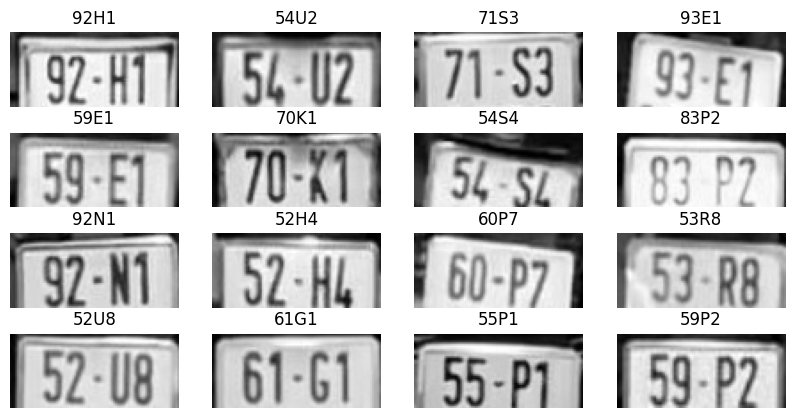

In [7]:
_, ax = plt.subplots(4, 4, figsize = (10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i]*255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i//4, i%4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i//4, i%4].set_title(label)
        ax[i//4, i%4].axis("off")
plt.show()

In [8]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name = name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length*tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length*tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [9]:
img_width//4, img_height//4

(23, 10)

In [16]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None, ), dtype="float32")
    
    x = layers.Conv2D(32, (3, 3), activation=None, kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.AveragePooling2D((2, 2), name="pool1")(x)
    
    x = layers.Conv2D(64, (3, 3), activation=None, kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.AveragePooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((img_width//4), (img_height//4)*64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    model = keras.Model(inputs = [input_img, labels], outputs=output, name="ocr_model_v1")
    
    opt = keras.optimizers.Adam(learning_rate = 1e-3)
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 95, 42, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 95, 42, 32)   320         ['image[0][0]']                  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 95, 42, 32)  128         ['Conv1[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 95, 42, 32)   0           ['batch_normalization_

In [17]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=early_stopping_patience, restore_best_weights=True)

history = model.fit(train_dataset, epochs = epochs, callbacks=[early_stopping])

Epoch 1/200
20/20 [==============================] - 8s 77ms/step - loss: 21.8000
Epoch 2/200
20/20 [==============================] - 2s 74ms/step - loss: 13.4599
Epoch 3/200
20/20 [==============================] - 2s 72ms/step - loss: 12.9146
Epoch 4/200
20/20 [==============================] - 2s 72ms/step - loss: 12.5736
Epoch 5/200
20/20 [==============================] - 2s 72ms/step - loss: 12.3346
Epoch 6/200
20/20 [==============================] - 2s 72ms/step - loss: 12.1666
Epoch 7/200
20/20 [==============================] - 2s 72ms/step - loss: 12.0068
Epoch 8/200
20/20 [==============================] - 2s 71ms/step - loss: 11.8735
Epoch 9/200
20/20 [==============================] - 2s 72ms/step - loss: 11.6969
Epoch 10/200
20/20 [==============================] - 1s 69ms/step - loss: 11.4717
Epoch 11/200
20/20 [==============================] - 1s 69ms/step - loss: 11.2329
Epoch 12/200
20/20 [==============================] - 1s 71ms/step - loss: 10.9870
Epoch 13/200


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 95, 42, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 95, 42, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 95, 42, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 95, 42, 32)        0         
                                                                 
 pool1 (AveragePooling2D)    (None, 47, 21, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 47, 21, 64)        18496     
                                                             

IndexError: index 4 is out of bounds for axis 0 with size 4

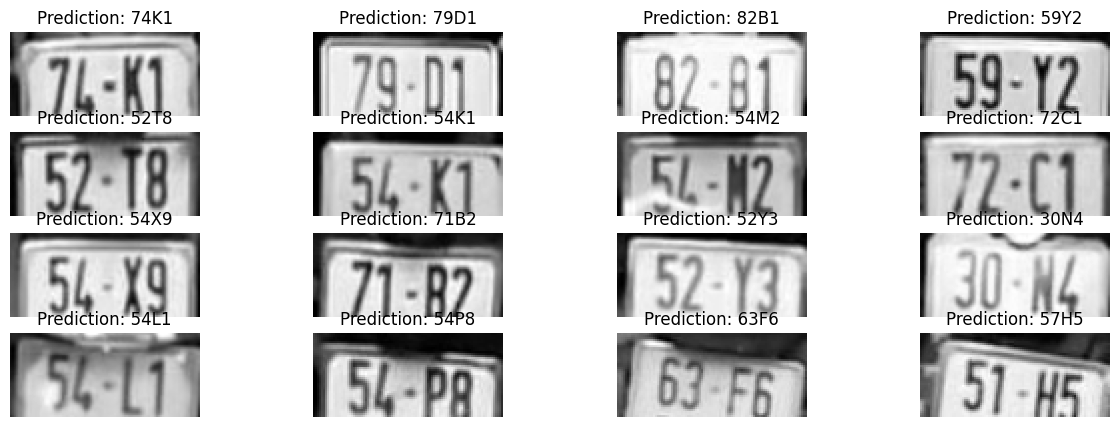

In [18]:
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)

prediction_model.summary()

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in train_dataset.take(2):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
sample = images[11][None, ...]

In [24]:
def decodePred(pred):
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    result = keras.backend.ctc_decode(pred, input_len, greedy=True)[0][0][:, :4]
    return tf.strings.reduce_join(num_to_char(result)).numpy().decode()

In [27]:
tf.ones(pred.shape[0])*pred.shape[1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([23.], dtype=float32)>

In [26]:
pred = prediction_model(sample)

In [28]:
decodePred(pred)

'53R8'

In [32]:
inp = layers.Input((95, 42, 1))
x = prediction_model(inp)
x = keras.backend.ctc_decode(x, tf.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0][:, :4]
oup = tf.strings.reduce_join(num_to_char(x))
finalModel = keras.Model(inputs = inp, outputs = oup)

In [33]:
finalModel.save("upper_digit_recognizer.h5")

In [ ]:
newModel = tf.keras.models.load_model("lower_digit_recognizer.h5")